### ** PROJECT 1: Automaitc Land Finding**
***

My first Jupyter Notebook. Hopefully it would go well

#### Goal:
    1. Apply Canny Transformation, Hough Transformation to extract lane lines in a given frame (or image)
    2. Familiar myself with OpenCV and numpy operation.
    3. Believe that I can be a self-driving engineer :D [ I used to attempt to work on self-driving car projects many times but I always failed because I did not have a mentor nor lacked of knowledge.


In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math

# Import everything needed to edit/save/watch video clips
import moviepy
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

** My PipeLine/Algorithm **

Global Variables:

* previous_left_right_slopes = []

* previous_polygon_vertices  = []


For every frame in a video:
    1. Apply Canny Edge and Hough Transform         
    3. Mask Region of Intrest         
    3. For each line segments:
        a. Calculate the slope
            if (slope > 0): 
                add to right_slopes
                compare to Max_point (highest ponint) and Min_point (lowest_point).
            if (slope < 0): 
                add to left_slopes
                compare to Max_point and Min_point.
    4. Calcualte Median left and right slopes relatively to previous slope
    5. Draw lines on the image
        

### ** Here are some of helper functions for the main pipeline**


In [2]:
def draw_lanes(source_img, lines, color=[255, 0, 0], thickness=2):
    """ 
    Draw left and right lines to the image
    
    :param source_img : a source image
    :param lines      : a list of lines
    :param color      : color of the line
    :param thickness  : thickness of the line
    
    :return: an image with lines on it
    """
    
    img = np.copy(source_img)
    

    return img


def draw_line_segments(source_image, h_lines, color=[255, 0, 0], thickness=2):
    """
    Draw the line segments to the source images.
    """

    line_img = np.copy(source_image)

    for a_line in h_lines:
        for x1, y1, x2, y2 in a_line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
    return line_img


In [3]:
def edge_detector(gray_img, gaussian_kernel_size=1, low_threshold=0, high_threshold=10):
    """
    Return possible edges in an image using Canny Transformation
    :param gray_img:             a grayed image
    :param gaussian_kernel_size: a kernel size for gaussian blur [default is 0]
    :param low_threshold:        default is 0
    :param high_threshold:       default is 10
    :return: edges in an image
    """
    
    # Apply gaussian blur  
    kernel_size = (gaussian_kernel_size, gaussian_kernel_size)
    blurred_image = cv2.GaussianBlur(gray_img, kernel_size, 0)

    # Canny Edge Detection
    canny_edges = cv2.Canny(blurred_image, low_threshold, high_threshold)
    return canny_edges


def find_hough_lines(edge_img, min_votes, min_length, max_gap):
    """
    Return a list of possible Hough Lines in edge_img
    
    :param edge_img:    a canny edge image
    :param min_votes:   a minimum threshold [votes] to be considered a possible line
    :param min_length:  a minimum length to be considered a line
    :param max_gap:     maximum gap between points that have the same line
    :return:            a list of possible lines
    
    Notice : a line in openCV contains : 2 vertices (x1,y1) and (x2,y2)
    """
    
    rho = 1             # perpendicular distance from origin to a line
    theta = np.pi/180   # angle between line and x-axis
    
    # Hough Transform Built-in function of OpenCV. Return a line segments in image
    lines = cv2.HoughLinesP(edge_img, rho, theta, min_votes, np.array([]), min_length, max_gap)

    return lines



def region_of_interest(img, vertices):
    """
    Filter out not-so-important region in the image
    :param source_img:
    :param vertices:    list of vertices to create a polygon
    :return:
    """
    mask = np.zeros_like(img)
    ignore_mask_color = 255
    
     #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_edges = cv2.bitwise_and(img, mask)
    return masked_edges


def adaptive_equalize_image(img, level):
    """
    Equalize an image - Increase contrast for the image
        # http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html
        
    :param img:    an gray image
    :param level:  clipLevel
    :return: a equalized image
    """
    clahe = cv2.createCLAHE(clipLimit=level)
    result = clahe.apply(img)
    return result

### ** Helper functions **

In [4]:
def gray_image(img):
    """
    Convert color image into gray scale image
    :param img: a color image
    :return: a gray image
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


def calculate_slope(line):
    """
    Calculate a slope of a line segment
    :param line:
    :return: slope value
    """
    slope = 0
    for x1, y1, x2, y2 in line:
        slope = (y1 - y2)/(x1 - x2)
    return slope


def update_boundary(line_segment, curr_max, curr_min):
    """
    Update max point and min point of the line
    """
    for x1, y1, x2, y2 in line_segment:
        if  y1 < curr_max[1]:
            curr_max = [x1, y1]
            
        elif y1 > curr_min[1]:
            curr_min = [x1, y1]
            
        if  y2 < curr_max[1]:
            curr_max = [x2, y2]
            
        elif y2 > curr_min[1]:
            curr_min = [x2, y2]
    
    return [curr_max, curr_min]


def calculate_intercept(max_point, min_point, avg_slope):
    """
    find new intercept y for max and min point relative to average slope
    
    y = kx + b
    
    """
    slope = (max_point[1] - min_point[1])/ (max_point[0] - min_point[0])
    b = max_point[1] - slope*max_point[0]
    
    # Update new intercept relavtive to average slope
    max_point[0] = int(avg_slope*max_point[1] + b)
    min_point[0] = int(avg_slope*min_point[1] + b)
    
    return (max_point, min_point)

def fit_line(img, line):
    """
    Add line to image
    :param img:
    :param line:
    :return:
    """
    cols = img.shape[1]
    [vx, vy, x, y] = cv2.fitLine(line, cv2.DIST_L2, 0, 0.01, 0.01)
    slope = (vy-y)/(vx-x)
    lefty = int((-x * vy / vx) + y)
    righty = int(((cols - x) * vy / vx) + y)
    cv2.line(img, (cols - slope, righty), (0, lefty), (255, 0, 0), 10)
    return img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


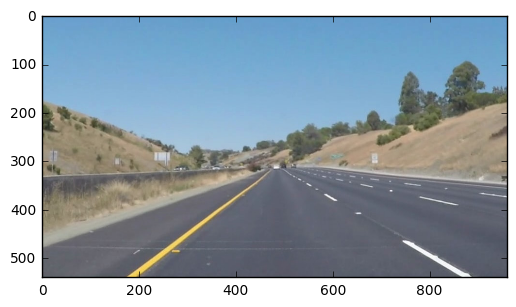

In [5]:
image = mpimg.imread('./test_images/whiteCarLaneSwitch.jpg')

plt.imshow(image)
print('This image is:', type(image), 'with dimensions:', image.shape)

### ** Initialize polygon vertices and slopes **

In [15]:
im_shape = image.shape
xsize = im_shape[0]
ysize = im_shape[1]

# Points of polygon
left_top = (ysize * 0.55, xsize * 0.5)
left_bottom = (0, xsize)

right_top = (ysize * 0.52, xsize * 0.5)
right_bottom = (ysize, xsize)
vertices = np.array([[left_top, right_top, left_bottom, right_bottom]], dtype=np.int32)

# Initial points
max_left = [ysize, xsize]
min_left = [0, 0]

max_right = [ysize * 0.52, xsize * 0.5]
min_right = [0, 0]

#Initial slopes
slopes = []
right_slopes = []
left_slopes = []


# print(xsize, ysize)
 # print(vertices)

In [21]:
# Apply Canny Edge Detection
canny = edge_detector(image, 3, 350, 130)

#plt.imshow(canny, cmap='gray')
# Mask a Region Of Interest 
edges = region_of_interest(canny, vertices)
print(edges.shape)

(540, 960)


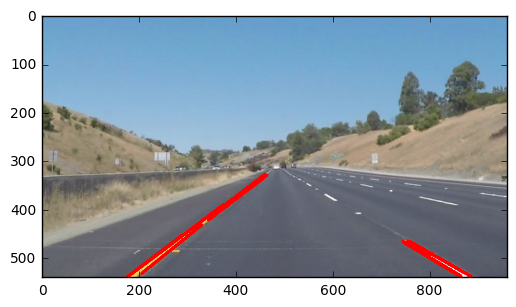

In [28]:
color_edges = np.dstack((edges, edges, edges)) 

# Hough Transform
h_lines = find_hough_lines(edges, 9, 50, 10)

line_img = draw_line_segments(image, h_lines, [255, 0, 0], 5)
plt.imshow(line_img)

In [19]:
for line in h_lines:
    slope = calculate_slope(line)
    if slope > 0:
        right_slopes.append(slope)
        [max_right, min_right] = update_boundary(line, max_right, min_right)
    if slope < 0:
        left_slopes.append(slope)
        [max_left, min_left] = update_boundary(line, max_left, min_left)
print(max_right, min_right)
print(max_left,min_left)
max_right = [int(max_right[0]), int(max_right[1])]

[499, 270] [0, 0]
[466, 326] [176, 539]


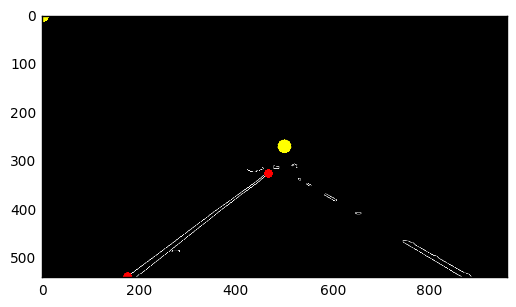

In [20]:
average_right_slope = np.median(right_slopes)
average_left_slope = np.median(left_slopes)



point_image = cv2.circle(color_edges, (min_right[0], min_right[1]), 4, [255, 255, 0], 20)
point_image = cv2.circle(color_edges, (max_right[0], max_right[1]), 4, [255, 255, 0], 20)

point_image = cv2.circle(color_edges, (max_left[0], max_left[1]), 4, [255, 0, 0], 10)
point_image = cv2.circle(color_edges, (min_left[0], min_left[1]), 4, [255, 0, 0],10)
plt.imshow(point_image)



In [ ]:


right_line = np.array([[max_right[0], max_right[1], min_right[0], min_right[1]]])
left_line  = np.array([[max_left[0],  max_left[1],  min_left[0],  min_left[1]]])

line_image = draw_line_segments(color_edges, [right_line], [255, 0, 0], 10)
line_image = draw_line_segments(line_image, [left_line], [255, 255, 0], 15)

# Draw the lines on the edge image
lines_edges = weighted_img(color_edges, line_image)
plt.imshow(lines_edges)


### ** Calculate y intercept using current points **

In [ ]:
# # Create a "color" binary image to combine with line image
# color_edges = np.dstack((edges, edges, edges)) 

# line_image = draw_line_segments(color_edges, h_lines, color=[255, 0, 0], thickness=2)
# # Draw the lines on the edge image
# lines_edges = weighted_img(color_edges, line_image)
# plt.imshow(lines_edges)